# Animal Image Classification

### Import necessary libraries

In [ ]:
import os
import random
import shutil

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.18.0
NumPy version: 2.0.2


### Dataset Creation and Plotting Function

In [ ]:
SEED = 32

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
dataset_dir = "/content/drive/MyDrive/ceng506/hw2/dataset"
output_dir = "/content/drive/MyDrive/ceng506/hw2/splitted_dataset"

In [ ]:
def training_hist_plot(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
train_dir = os.path.join(output_dir, "train")
validation_dir = os.path.join(output_dir, "validation")

os.makedirs(output_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [ ]:
validation_split_ratio = 0.2

classes = ["alpaca", "bear", "elephant", "leopard", "zebra"]

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, cls), exist_ok=True)

    class_path = os.path.join(dataset_dir, cls)
    images = sorted([img for img in os.listdir(class_path) if img.endswith(('.JPEG', '.jpg', '.png'))])

    train_images, val_images = train_test_split(images, test_size=validation_split_ratio, random_state=SEED)

    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(validation_dir, cls, img)
        shutil.copy(src, dst)

    print(f"{cls}: {len(train_images)} training, {len(val_images)} validation images")

alpaca: 113 training, 29 validation images
bear: 128 training, 32 validation images
elephant: 128 training, 32 validation images
leopard: 128 training, 32 validation images
zebra: 128 training, 32 validation images


## Baseline Model


### Prepare Dataset

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

print("Training Data")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Validation Data")
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Training Data
Found 761 images belonging to 5 classes.
Validation Data
Found 293 images belonging to 5 classes.


### Create Baseline Model

In [ ]:
def create_baseline_model(class_count: int):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(class_count, activation='softmax')  # 5 classes
    ])

    return model

In [ ]:
baseline_model = create_baseline_model(len(classes))
baseline_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# baseline_model.summary()

### Train Model

In [ ]:
EPOCHS = 20

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 654ms/step - accuracy: 0.2064 - loss: 2.0984 - val_accuracy: 0.2986 - val_loss: 1.4947
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2812 - loss: 1.5015 - val_accuracy: 0.3542 - val_loss: 1.4803
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 591ms/step - accuracy: 0.2714 - loss: 1.4993 - val_accuracy: 0.3438 - val_loss: 1.7488
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2812 - loss: 1.3348 - val_accuracy: 0.3854 - val_loss: 1.5828
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - accuracy: 0.3834 - loss: 1.3979 - val_accuracy: 0.4757 - val_loss: 1.2957
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4062 - loss: 1.1627 - val_accuracy: 0.4688 - val_loss: 1.3385
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - accuracy: 0.4798 - loss: 1.2246 - val_accuracy: 0.5764 - val_loss: 1.0670
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6562 - loss: 1.0773 - val_accuracy: 0.

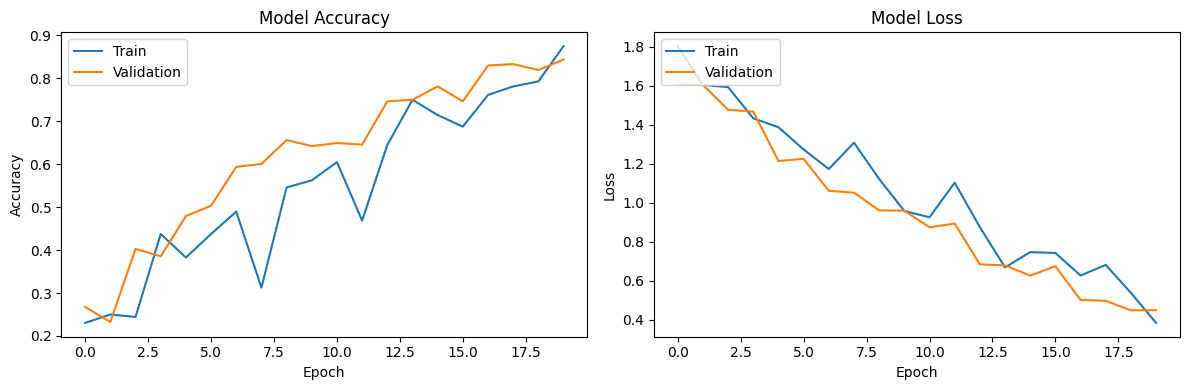

In [ ]:
training_hist_plot(history_baseline)

## Transfer Learning

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 891ms/step - accuracy: 0.8180 - loss: 0.4853 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.9974 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 5.7485e-04 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.9970 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 8.0334e-04
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 3.9781e-04 - val_accuracy: 1.0000 - val_loss: 8.1801e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 1.0000 - loss: 7.0322e-04 - val_accuracy: 1.0000 - val_loss: 4.2089e-04
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 1.0000 - loss: 2.32

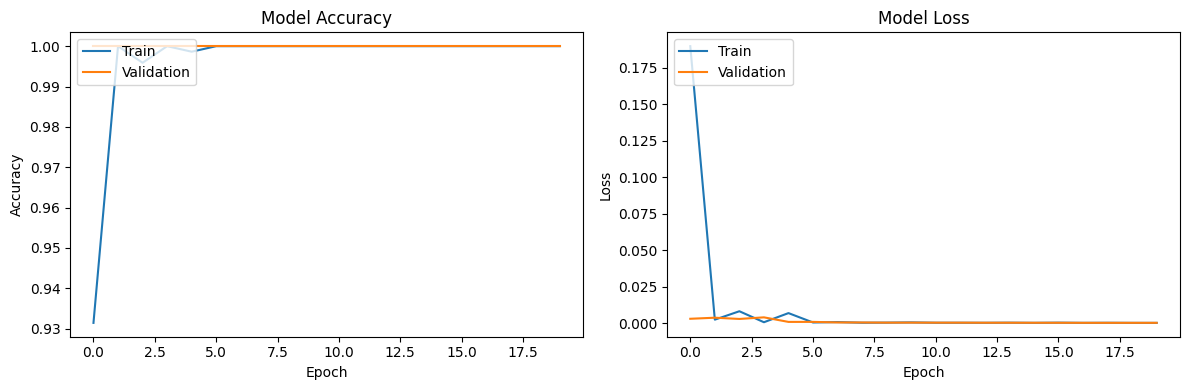

In [ ]:
def create_transfer_learning_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False   # Freeze the base model layers

    # Custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

transfer_model = create_transfer_learning_model()

transfer_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = transfer_model.fit(
    train_generator,
    callbacks=[early_stop],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

training_hist_plot(history_transfer)

## Baseline model with Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

EPOCHS = 20

history_augmented = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Found 761 images belonging to 5 classes.
Found 293 images belonging to 5 classes.
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 596ms/step - accuracy: 0.5559 - loss: 1.1848 - val_accuracy: 0.7604 - val_loss: 0.6772
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5625 - loss: 1.0316 - val_accuracy: 0.7778 - val_loss: 0.6597
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - accuracy: 0.6092 - loss: 0.9476 - val_accuracy: 0.7986 - val_loss: 0.6191
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5312 - loss: 1.1492 - val_accuracy: 0.8021 - val_loss: 0.6273
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 574ms/step - accuracy: 0.6463 - loss: 0.9088 - val_accuracy: 0.7812 - val_loss: 0.6318
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6562 - loss: 0.7985 - val_accuracy: 0.7500 - val_loss: 0.6704
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 580ms/step - accuracy: 0.6256 - loss: 0.9129 - val_accuracy: 0.8507 - val_loss: 0.4762
Epoch 8/20
23/23 ━━━━

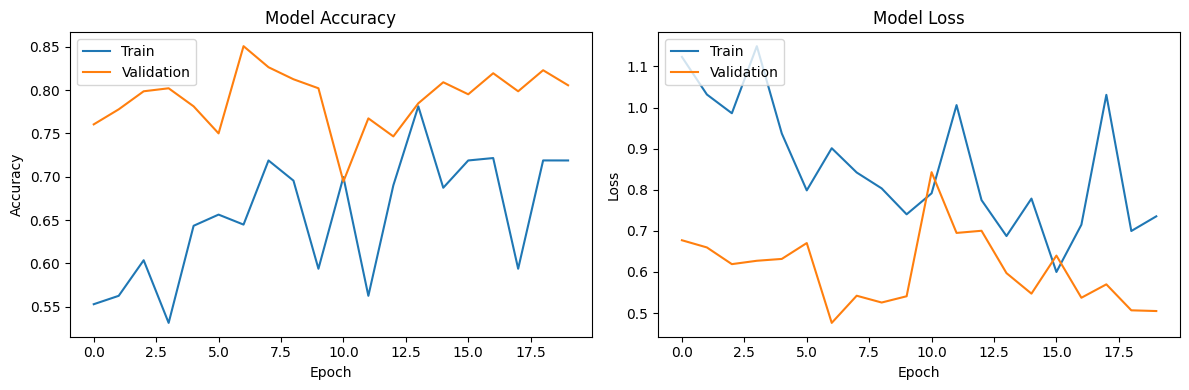

In [ ]:
training_hist_plot(history_augmented)

## Transfer Learning & Data Augmentation

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 605ms/step - accuracy: 0.9870 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 7.6578e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 1.0000 - val_loss: 7.1015e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 568ms/step - accuracy: 0.9875 - loss: 0.0401 - val_accuracy: 0.9757 - val_loss: 0.0833
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9375 - loss: 0.0933 - val_accuracy: 0.9792 - val_loss: 0.0405
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 579ms/step - accuracy: 0.9835 - loss: 0.0612 - val_accuracy: 0.9965 - val_loss: 0.0306


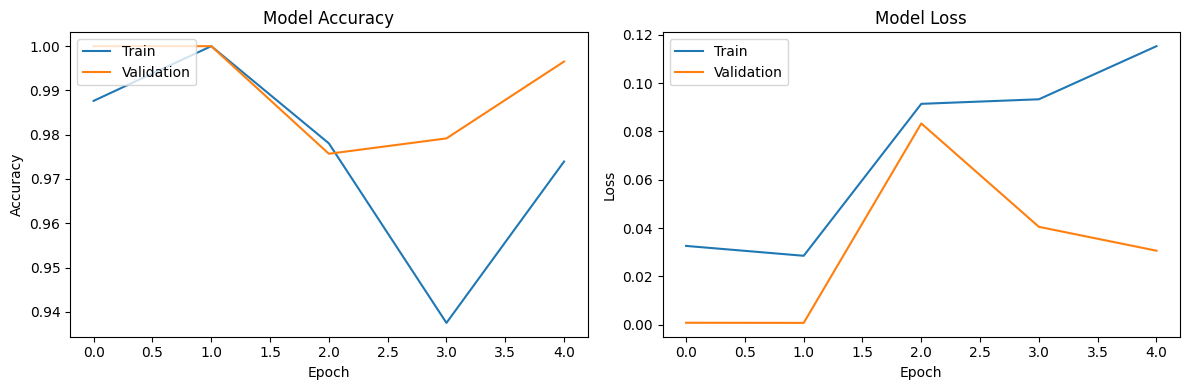

In [ ]:
# The model we have created earlier
history_combined = transfer_model.fit(
    train_generator,
    callbacks=[early_stop],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,     # Augmented Data
    validation_steps=validation_generator.samples // BATCH_SIZE
)

training_hist_plot(history_combined)

# Compare the Results

### Notes
- The baseline model is learning appropriately and generalizing reasonably well to the validation set.
- Data Augmentation introduces instability in training, especially in the loss curves.
- Transfer learning using MobileNetV2 leads to high and stable accuracy for both training and validation (around ~99%). Very low and consistent loss values across epochs.
- Combining transfer learning with data augmentation, achieves similarly high validation accuracy as transfer learning alone. This combination offers increased robustness without sacrificing performance.

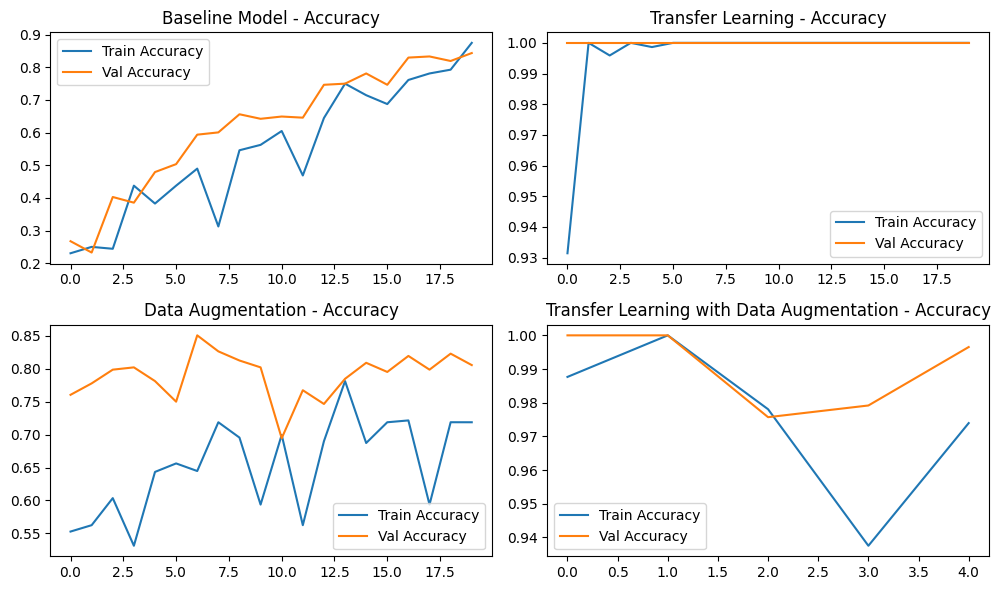

In [ ]:
# Plot metrics for all models to compare them
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Baseline
axs[0, 0].plot(history_baseline.history['accuracy'], label='Train Accuracy')
axs[0, 0].plot(history_baseline.history['val_accuracy'], label='Val Accuracy')
axs[0, 0].set_title('Baseline Model - Accuracy')
axs[0, 0].legend()

# Transfer learning
axs[0, 1].plot(history_transfer.history['accuracy'], label='Train Accuracy')
axs[0, 1].plot(history_transfer.history['val_accuracy'], label='Val Accuracy')
axs[0, 1].set_title('Transfer Learning - Accuracy')
axs[0, 1].legend()

# Data Augmentation
axs[1, 0].plot(history_augmented.history['accuracy'], label='Train Accuracy')
axs[1, 0].plot(history_augmented.history['val_accuracy'], label='Val Accuracy')
axs[1, 0].set_title('Data Augmentation - Accuracy')
axs[1, 0].legend()

# Transfer Learning with Data Augmentation
axs[1, 1].plot(history_combined.history['accuracy'], label='Train Accuracy')
axs[1, 1].plot(history_combined.history['val_accuracy'], label='Val Accuracy')
axs[1, 1].set_title('Transfer Learning with Data Augmentation - Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

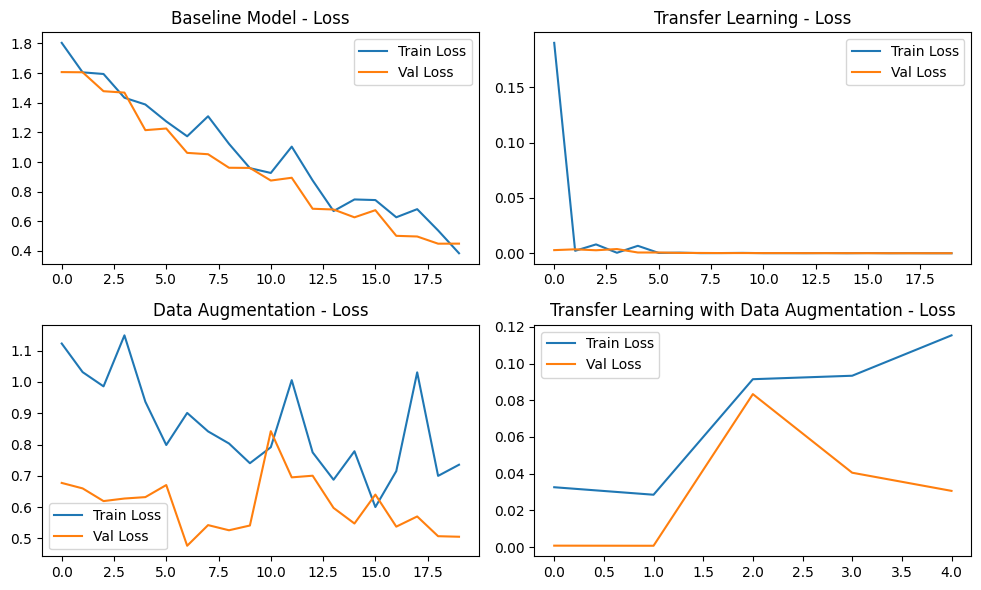

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Baseline
axs[0, 0].plot(history_baseline.history['loss'], label='Train Loss')
axs[0, 0].plot(history_baseline.history['val_loss'], label='Val Loss')
axs[0, 0].set_title('Baseline Model - Loss')
axs[0, 0].legend()

# Transfer Learning
axs[0, 1].plot(history_transfer.history['loss'], label='Train Loss')
axs[0, 1].plot(history_transfer.history['val_loss'], label='Val Loss')
axs[0, 1].set_title('Transfer Learning - Loss')
axs[0, 1].legend()

# Data Augmentation
axs[1, 0].plot(history_augmented.history['loss'], label='Train Loss')
axs[1, 0].plot(history_augmented.history['val_loss'], label='Val Loss')
axs[1, 0].set_title('Data Augmentation - Loss')
axs[1, 0].legend()

# Transfer Learning with Data Augmentation
axs[1, 1].plot(history_combined.history['loss'], label='Train Loss')
axs[1, 1].plot(history_combined.history['val_loss'], label='Val Loss')
axs[1, 1].set_title('Transfer Learning with Data Augmentation - Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()